<a href="https://colab.research.google.com/github/hnidey13/tesis_SVD_t-SVDM/blob/main/Ejemplo_SVD_(Iris).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cargamos librerías y leemos el conjunto de datos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd, norm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import h5py
import os
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target
X_train,X_test,training_labels,test_labels=train_test_split(X,y,test_size=0.1,random_state=1)

print(iris.feature_names)
print(iris.target_names)

shape1 = training_labels.shape
shape2 = test_labels.shape

x_train = pd.DataFrame(np.transpose(X_train,(1,0)))

y_train = pd.DataFrame(training_labels.reshape(1,shape1[0]))

x_test = pd.DataFrame(np.transpose(X_test,(1,0)))
y_test = pd.DataFrame(test_labels.reshape(1,shape2[0]))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(4, 135)
(1, 135)
(4, 15)
(1, 15)


Centrar datos

In [ ]:
#x_train = x_train.apply(lambda x: x-x.mean(),1)
#x_test = x_test.apply(lambda x: x-x.mean(),1)
#x_train.mean(1)[0]

Creamos matrices $A_0,A_1,A_2$ de forma que contengan a las imágenes con los dígitos correspondientes y las guardamos en un diccionario.

In [ ]:
alpha_matrices={}
for i in range(3):
    alpha_matrices.update({"A"+str(i):x_train.loc[:,list(y_train.loc[0,:]==i)]})
print(
    len(alpha_matrices),
    list(map(lambda l: l.shape, alpha_matrices.values()))    
    )


3 [(4, 45), (4, 44), (4, 46)]


Realizamos SVD para cada una de las 3 matrices

In [ ]:
left_singular={}
singular_matrix={}
right_singular={}
for i in range(3):
    u, s, v_t = svd(alpha_matrices['A'+str(i)], full_matrices=False)
    left_singular.update({"u"+str(i):u})
    singular_matrix.update({"s"+str(i):s})
    right_singular.update({"v_t"+str(i):v_t})

print(list(map(lambda l: l.shape, left_singular.values())))
print(list(map(lambda l: l.shape, singular_matrix.values())))
print(list(map(lambda l: l.shape, right_singular.values())))

print(left_singular.keys())
print(singular_matrix.keys())
print(right_singular.keys())

[(4, 4), (4, 4), (4, 4)]
[(4,), (4,), (4,)]
[(4, 45), (4, 44), (4, 46)]
dict_keys(['u0', 'u1', 'u2'])
dict_keys(['s0', 's1', 's2'])
dict_keys(['v_t0', 'v_t1', 'v_t2'])


Graficamos los valores singulares en escala normal

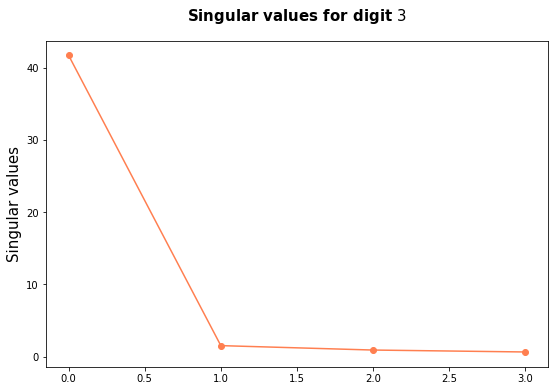

In [ ]:
plt.figure(figsize = (9, 6))
plt.plot(singular_matrix['s0'], color='coral', marker='o')
plt.title('Singular values for digit $3$',fontsize=15,weight='bold',pad=20)
plt.ylabel('Singular values' ,fontsize=15)
#plt.yscale('log')
plt.show()

Para el conjunto de entrenamiento probamos distintos valores de $k\in \{0,...,4\}$

In [ ]:
I = np.eye(x_train.shape[0])
kappas=np.arange(0,5)
len_test=x_train.shape[1]
predictions=np.empty((y_train.shape[1],0), dtype = int)
for t in list(kappas):
    prediction = []
    for i in range(len_test):
        residuals = []
        for j in range(3):
            u=left_singular["u"+str(j)][:,0:t]
            res=norm((I - u @ u.T) @ x_train[i])
            residuals.append(res)
        index_min = np.argmin(residuals)
        prediction.append(index_min)
        
    prediction=np.array(prediction)
    predictions=np.hstack((predictions,prediction.reshape(-1,1)))
scores=[]
for i in range(len(kappas)):
    score=accuracy_score(y_train.loc[0,:],predictions[:,i])
    scores.append(score)
data={"Number of basis vectors":list(kappas), "accuracy_score":scores}
df=pd.DataFrame(data).set_index("Number of basis vectors")
df

,accuracy_score
Number of basis vectors,
0,0.333333
1,0.970370
2,0.970370
3,0.748148
4,0.325926


Grafica de resultados

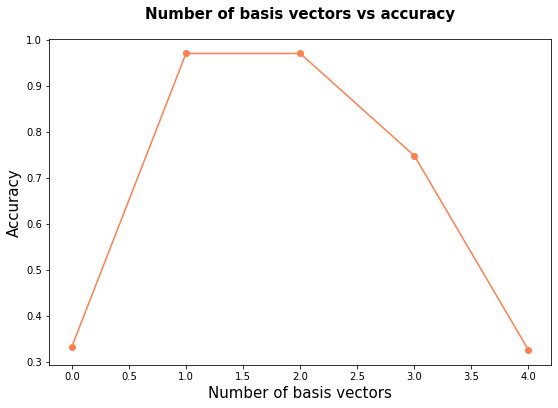

In [ ]:
plt.figure(figsize = (9, 6))
plt.plot(df["accuracy_score"], color='coral', marker='o')
plt.title('Number of basis vectors vs accuracy',fontsize=15,weight='bold',pad=20)
plt.xlabel('Number of basis vectors' ,fontsize=15)
plt.ylabel('Accuracy' ,fontsize=15)
plt.show()

Ahora con el conjunto de prueba usamos el mejor $k$

In [ ]:
I = np.eye(x_test.shape[0])
kappas=np.arange(2,3)
len_test=x_test.shape[1]
predictions=np.empty((y_test.shape[1],0), dtype = int)
for t in list(kappas):
    prediction = []
    for i in range(len_test):
        residuals = []
        for j in range(3):
            u=left_singular["u"+str(j)][:,0:t]
            res=norm((I - u @ u.T) @ x_test[i])
            residuals.append(res)
        index_min = np.argmin(residuals)
        prediction.append(index_min)
        
    prediction=np.array(prediction)
    predictions=np.hstack((predictions,prediction.reshape(-1,1)))
scores=[]
for i in range(len(kappas)):
    score=accuracy_score(y_test.loc[0,:],predictions[:,i])
    scores.append(score)
data={"Number of basis vectors":list(kappas), "accuracy_score":scores}
df=pd.DataFrame(data).set_index("Number of basis vectors")
df

,accuracy_score
Number of basis vectors,
2,0.933333


Matriz de confusión

In [ ]:
pd.set_option('display.max_colwidth',12)
confusion_matrix_df = pd.DataFrame( confusion_matrix(y_test.loc[0,:],predictions[:,0]) )
confusion_matrix_df = confusion_matrix_df.rename(columns = {0:iris.target_names[0],1:iris.target_names[1],2:iris.target_names[2]},
                                                 index = {0:iris.target_names[0],1:iris.target_names[1],2:iris.target_names[2]})
confusion_matrix_df

,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,6,0
virginica,0,1,3


Score F1

In [ ]:
print(classification_report(y_test.loc[0,:],predictions[:,0]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.75      0.86         4

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15

